In [1]:
%load_ext autoreload
%autoreload 2


import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from model import LSTM_fixed_len
from train import *
from utils import ReviewsDataset
from sklearn.utils import class_weight
from pyvi import ViTokenizer
from sklearn.metrics import confusion_matrix,classification_report
from collections import Counter

# Load data

In [2]:
%pwd

'/home/taindp/PycharmProjects/text_classifcation'

In [3]:
data_path = '/home/taindp/PycharmProjects/text_classifcation/data'
model_path = '/home/taindp/PycharmProjects/text_classifcation/model'

In [4]:
question = pd.read_csv(os.path.join(data_path,'question_livestream_label.csv'))

In [5]:
question

,label,content
0,1,thầy cho em hỏi nếu mình đã trúng tuyển chương...
1,0,cho em hỏi em có thể đăng kí 2 ngành được khôn...
2,1,cho em hỏi chương trình chất lượng cao ở bách ...
3,1,cho em hỏi nếu em đã trúng tuyển chương trình ...
4,0,thầy ơi cho em hỏi ví dụ nếu mình chọn nguyện ...
...,...,...
428,3,cho em hỏi về ngành kỹ thuật hoá học và cơ hội...
429,3,cho em xin giới thiệu về ngành kỹ thuật robot ạ
430,3,ngành khoa học máy tính sau này ra làm công vi...
431,3,em muốn học tự động hoá thì tương lai sẽ có ng...


In [6]:
question['length'] = [len(item) for item in list(question['content'])]
question['num_word'] = [len(item.split(' ')) for item in list(question['content'])]

In [7]:
np.mean(question['num_word'])

17.02540415704388

(array([ 97., 169.,  86.,  48.,  25.,   4.,   3.,   0.,   0.,   1.]),
 array([ 6. , 11.6, 17.2, 22.8, 28.4, 34. , 39.6, 45.2, 50.8, 56.4, 62. ]),
 <BarContainer object of 10 artists>)

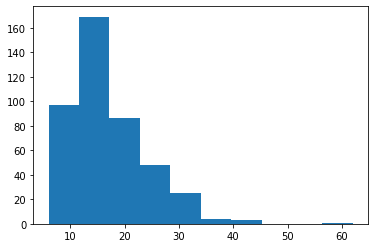

In [8]:
plt.hist(list(question['num_word']), bins = 10)

In [9]:
def tokenize(text):
    list_token = ViTokenizer.tokenize(text)
    return list_token.split(' ')

In [10]:
counts = Counter()
for index, row in question.iterrows():
    counts.update(tokenize(row['content']))

In [11]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 616
num_words after: 365


In [12]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [13]:
def encode_sentence(text, vocab2index, N=75):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
#     print(len(enc1))
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
#     print(len(encoded))
    return [encoded]
#     return encoded, length

In [14]:
N = 30
question['encoded'] = question['content'].apply(lambda x: np.array(encode_sentence(x,vocab2index)))
question.head()

,label,content,length,num_word,encoded
0,1,thầy cho em hỏi nếu mình đã trúng tuyển chương...,159,33,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ..."
1,0,cho em hỏi em có thể đăng kí 2 ngành được khôn...,137,33,"[[3, 4, 5, 4, 13, 25, 26, 27, 22, 23, 4, 25, 2..."
2,1,cho em hỏi chương trình chất lượng cao ở bách ...,106,24,"[[3, 4, 5, 10, 16, 17, 32, 33, 34, 22, 35, 36,..."
3,1,cho em hỏi nếu em đã trúng tuyển chương trình ...,148,31,"[[3, 4, 5, 6, 4, 8, 9, 10, 11, 12, 4, 13, 40, ..."
4,0,thầy ơi cho em hỏi ví dụ nếu mình chọn nguyện ...,273,62,"[[2, 41, 3, 4, 5, 42, 6, 7, 43, 44, 45, 46, 47..."


In [15]:
X = list(question['encoded'])
y = list(question['label'])

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=(1-0.693))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [16]:
len(X_train)

324

In [17]:
# class_weights = class_weight.compute_class_weight('balanced',np.unique(y).tolist(),y)
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train).tolist(),y_train)
class_weights = torch.tensor(class_weights,dtype=torch.float)
class_weights

/home/taindp/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0, 1, 2, 3], y=[3, 2, 2, 1, 1, 2, 1, 3, 2, 3, 1, 3, 2, 1, 1, 2, 3, 0, 1, 3, 2, 2, 2, 1, 0, 0, 2, 1, 3, 3, 3, 3, 1, 3, 3, 3, 2, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 3, 1, 3, 0, 3, 0, 1, 2, 3, 2, 0, 2, 0, 0, 1, 0, 2, 2, 3, 3, 0, 3, 2, 2, 3, 2, 3, 0, 0, 1, 0, 2, 2, 2, 0, 2, 0, 0, 3, 2, 2, 3, 0, 2, 3, 2, 3, 0, 2, 3, 3, 0, 0, 3, 0, 2, 1, 1, 3, 2, 3, 2, 3, 0, 3, 0, 0, 3, 3, 1, 2, 3, 2, 3, 2, 2, 3, 3, 0, 0, 0, 2, 1, 3, 3, 1, 1, 2, 0, 2, 2, 1, 3, 2, 3, 1, 1, 2, 2, 3, 3, 3, 3, 2, 1, 1, 0, 2, 0, 1, 2, 3, 3, 2, 1, 3, 2, 0, 2, 3, 2, 1, 0, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 1, 2, 2, 2, 2, 0, 2, 2, 1, 3, 2, 2, 3, 2, 0, 1, 2, 2, 3, 2, 3, 3, 3, 1, 1, 2, 2, 1, 2, 3, 1, 3, 3, 3, 0, 3, 2, 3, 0, 1, 2, 0, 0, 3, 1, 3, 3, 2, 2, 1, 3, 3, 0, 2, 3, 1, 2, 2, 0, 1, 2, 1, 2, 1, 3, 3, 0, 2, 2, 2, 3, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 0, 3, 2, 1, 0, 3, 3, 0, 3, 1, 3, 0, 3, 3, 2, 0, 2, 3, 2, 0, 2, 3, 3,

tensor([1.3065, 1.3729, 0.8617, 0.7431])

In [18]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [19]:
batch_size = 32
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [20]:
model_fixed =  LSTM_fixed_len(
                           vocab_size = vocab_size,\
                           embedding_dim = 400,\
                           hidden_dim = 100,\
                           num_layers = 2, \
                           bidirectional=True,\
                           dropout=0.5,\
                           n_class = class_weights.shape[0])
model_fixed.cpu()

LSTM_fixed_len(
  (embeddings): Embedding(367, 400, padding_idx=0)
  (lstm): LSTM(400, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [21]:
optimizer = torch.optim.Adam(model_fixed.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(weight = class_weights)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.4)

In [22]:

# loss=[]
# acc=[]
# val_loss=[]
# acc_max = 0
# for epoch in range(20):
#     train_loss = train_model(model_fixed,train_dl,optimizer,criterion)
#     valid_loss = evaluate (model_fixed, val_dl,criterion)
#     print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

#     print(f'\tTrain Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}')
# #     print(f'\t Val. Acc: {valid_acc*100:.2f}%')
#     print('='*50)
# #     print('pred',pred)
#     loss.append(train_loss)
# #     acc.append(train_acc)
#     val_loss.append(valid_loss)
#     exp_lr_scheduler.step()
#     list_true = []
#     for x,y in train_dl:
#         list_true.append(y)
# #     print(confusion_matrix(pred,list_true))

In [23]:

loss=[]
acc=[]
val_loss=[]
acc_max = 0

valid_loss_min = 1.

for epoch in range(30):
    train_loss = train_model(model_fixed,train_dl,optimizer,criterion)
    valid_loss = evaluate (model_fixed, val_dl,criterion)
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

    print(f'\tTrain Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}')
    
    if valid_loss < valid_loss_min:
        valis_loss_min = valid_loss
        checkpoint = {'model': model_fixed,
          'state_dict': model_fixed.state_dict(),
          'optimizer' : optimizer.state_dict()}
        valis_loss_save = str(valis_loss_min).replace('.','_')[:3]
        torch.save(checkpoint, os.path.join(model_path,'checkpoint_{}.pth'.format(valis_loss_save)))
#     print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    print('='*50)
#     print('pred',pred)
    loss.append(train_loss)
#     acc.append(train_acc)
    val_loss.append(valid_loss)
    exp_lr_scheduler.step()
    
        
    list_pred_train = []
    list_true_train = []
    
    for x,y in train_dl:
        x = x.long()
        pred = model_fixed(x)
        for item in pred:
            list_pred_train.append(item.argmax().item())
        for true in y:
            list_true_train.append(true.item())
            
    print('='*50)
    print('classify report train')
    
    print(classification_report(list_true_train,list_pred_train))
    
    ## validation
        
    list_pred_valid = []
    list_true_valid = []
    
    for x,y in val_dl:
        x = x.long()
        pred = model_fixed(x)
        for item in pred:

            list_pred_valid.append(item.argmax().item())
        for true in y:
            list_true_valid.append(true.item())
            
    print('='*50)
    print('classify report valid')
            
    print(classification_report(list_true_valid,list_pred_valid))
#     print(confusion_matrix(pred,list_true))

Epoch-0 lr: 0.01
	Train Loss: 1.377 | Valid Loss: 1.332
classify report train
              precision    recall  f1-score   support

           0       0.67      0.03      0.06        62
           1       0.53      0.93      0.67        59
           2       0.89      0.33      0.48        94
           3       0.53      0.88      0.66       109

    accuracy                           0.57       324
   macro avg       0.65      0.54      0.47       324
weighted avg       0.66      0.57      0.50       324

classify report valid
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.41      0.88      0.56        17
           2       1.00      0.18      0.30        28
           3       0.48      0.82      0.60        39

    accuracy                           0.48       109
   macro avg       0.47      0.47      0.37       109
weighted avg       0.49      0.48      0.38       109



/home/taindp/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch-1 lr: 0.01
	Train Loss: 1.244 | Valid Loss: 1.091
classify report train
              precision    recall  f1-score   support

           0       0.20      0.05      0.08        62
           1       0.61      0.97      0.75        59
           2       0.81      0.89      0.85        94
           3       0.74      0.75      0.75       109

    accuracy                           0.70       324
   macro avg       0.59      0.67      0.60       324
weighted avg       0.63      0.70      0.65       324

classify report valid
              precision    recall  f1-score   support

           0       0.33      0.08      0.13        25
           1       0.41      0.88      0.56        17
           2       0.53      0.71      0.61        28
           3       0.79      0.56      0.66        39

    accuracy                           0.54       109
   macro avg       0.51      0.56      0.49       109
weighted avg       0.56      0.54      0.51       109

Epoch-2 lr: 0.01
	Train Loss: 

classify report valid
              precision    recall  f1-score   support

           0       0.68      0.60      0.64        25
           1       0.72      0.76      0.74        17
           2       0.81      0.79      0.80        28
           3       0.86      0.92      0.89        39

    accuracy                           0.79       109
   macro avg       0.77      0.77      0.77       109
weighted avg       0.79      0.79      0.79       109

Epoch-9 lr: 0.004
	Train Loss: 0.672 | Valid Loss: 0.710
classify report train
              precision    recall  f1-score   support

           0       0.82      0.94      0.87        62
           1       1.00      0.97      0.98        59
           2       0.99      0.87      0.93        94
           3       0.96      1.00      0.98       109

    accuracy                           0.94       324
   macro avg       0.94      0.94      0.94       324
weighted avg       0.95      0.94      0.95       324

classify report valid
       

Epoch-16 lr: 0.00064
	Train Loss: 0.498 | Valid Loss: 0.728
classify report train
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        62
           1       1.00      0.98      0.99        59
           2       0.99      0.99      0.99        94
           3       0.97      1.00      0.99       109

    accuracy                           0.98       324
   macro avg       0.98      0.98      0.98       324
weighted avg       0.98      0.98      0.98       324

classify report valid
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        25
           1       0.71      0.71      0.71        17
           2       0.85      0.79      0.81        28
           3       0.85      0.90      0.88        39

    accuracy                           0.79       109
   macro avg       0.77      0.77      0.77       109
weighted avg       0.79      0.79      0.79       109

Epoch-17 lr: 0.00064
	Trai

classify report valid
              precision    recall  f1-score   support

           0       0.68      0.60      0.64        25
           1       0.71      0.71      0.71        17
           2       0.81      0.79      0.80        28
           3       0.81      0.90      0.85        39

    accuracy                           0.77       109
   macro avg       0.75      0.75      0.75       109
weighted avg       0.77      0.77      0.77       109

Epoch-24 lr: 0.00025600000000000004
	Train Loss: 0.551 | Valid Loss: 0.867
classify report train
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        62
           1       1.00      0.98      0.99        59
           2       0.98      1.00      0.99        94
           3       0.97      1.00      0.99       109

    accuracy                           0.98       324
   macro avg       0.98      0.98      0.98       324
weighted avg       0.98      0.98      0.98       324

classify re

In [25]:
# stop = 

In [26]:
checkpoint = {'model': model_fixed,
      'state_dict': model_fixed.state_dict(),
      'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, os.path.join(model_path,'model_apr7.pth'))

In [27]:
list_pred = []
list_true = []
for x,y in val_dl:
    x = x.long()
    pred = model_fixed(x)
    for item in pred:
#         print(item.argmax())
        list_pred.append(item.argmax().item())
    for true in y:
        list_true.append(true.item())
#         print(true.item())

In [28]:
confusion_matrix(list_pred,list_true)

array([[16,  2,  3,  2],
       [ 3, 12,  0,  2],
       [ 4,  1, 22,  0],
       [ 2,  2,  3, 35]])

In [29]:
np.average(f1_score(list_true, list_pred, average=None))

0.7591866376180101

# Test

In [30]:
load_model = load_checkpoint(os.path.join(model_path,'model_apr7.pth'))

In [31]:
load_model

LSTM_fixed_len(
  (embeddings): Embedding(367, 400, padding_idx=0)
  (lstm): LSTM(400, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# filename = os.path.join(model_path,'model_intent.pth')
# joblib.dump(load_model, filename)
# # with open('vectorizer.pickle', 'wb') as handle:
# #     pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
# import requests
# url = 'https://api-intent.herokuapp.com/predict'
# pred = requests.post(url,json={'message':'ad cho em hỏi chương trình tiên tiến với chất lượng cao khác nhau thế nào ạ'})
# print(pred.json())


In [ ]:
# for x,y in val_dl:
#     print(x.shape)

In [34]:
# vocab2index

In [35]:
torch.save(vocab2index,os.path.join(model_path,'vocab_apr7.pth'))

In [36]:
vocab2index = torch.load(os.path.join(model_path,'vocab_apr7.pth'))

In [38]:
N

30

In [40]:
test_sent = 'ad cho em hỏi ngành điện tử viễn thông có ổn không ạ'
test_enc =  torch.from_numpy(encode_sentence(test_sent, vocab2index, N)[0].astype(np.float32))
test_enc = torch.reshape(test_enc,(1,N))
test_enc

tensor([[316.,   3.,   4.,   5.,  27.,  97., 184.,  34.,   1.,  23.,  24.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.]])

In [41]:

preds = load_model(test_enc.long())
prop_preds = nn.functional.softmax(preds,dim=1)
print(prop_preds)
pred_label = prop_preds.argmax().item()
pred_label

tensor([[0.2745, 0.5609, 0.0350, 0.1296]])


1